#  CMIP6 

Links:
- https://www.nccs.nasa.gov/services/data-collections/land-based-products/nex-gddp-cmip6
- https://planetarycomputer.microsoft.com/dataset/nasa-nex-gddp-cmip6
- https://nex-gddp-cmip6.s3.us-west-2.amazonaws.com/index.html



Get file list

In [ ]:
# you need a recent version of OpenVisus packages
# uncomment as needed
if False:
  !pip install --upgrade OpenVisus openvisuspy


In [ ]:
import os
if not os.path.isfile("cmip6.txt"):
  !pip install aws-s3-tools
  !aws s3 ls --no-sign-request --recursive s3://nex-gddp-cmip6/NEX-GDDP-CMIP6/ > cmip6.txt

# Define some utilities

In [1]:
import sys,os, glob,shutil 
import numpy as np
import xarray as xr

import netCDF4

sys.path.append("C:/projects/OpenVisus/build/RelWithDebInfo")
sys.path.append("C:/projects/openvisuspy/src")

import OpenVisus as ov
import openvisuspy

from openvisuspy.create_streamable import Streamable
from openvisuspy.xarray_backend import OpenVisusBackendEntrypoint

# ////////////////////////////////////////////////////////
def ShowImage(img):
  import matplotlib.pyplot as plt
  import matplotlib.colors as colors
  fig, ax = plt.subplots(figsize=(8, 8))
  pos=ax.imshow(np.flip(img,axis=0), cmap="viridis")
  fig.colorbar(pos, ax=ax,location='right')
  plt.autoscale(True)
  plt.show()

# ////////////////////////////////////////////////////////
def DownloadObject(src,dst, endpoint_url=None):
  if os.path.isfile(dst): return
  print(f"DownloadObject {src} -> {dst}")
  assert(src.startswith("s3://"))
  import boto3
  session = boto3.session.Session()
  from botocore import UNSIGNED
  from botocore.config import Config
  s3_client = session.client(service_name='s3', config=Config(signature_version=UNSIGNED))
  __bucket,__name=src[len("s3://"):].split("/",maxsplit=1)
  os.makedirs(os.path.dirname(dst),exist_ok=True)
  s3_client.download_file(__bucket,__name, dst) 


# Count number of files and total size

As you see we have **~161K** netcdf files and **~41TB** of data

In [2]:
tot,files=0,[]
with open("cmip6.txt","r") as fin:
  for line in fin.readlines():
    if not line: continue
    date,time,size,url=line.split()

    ext=os.path.splitext(url)[1]
    
    # I am interested only in NETCDF files
    if ext!=".nc":
      continue
    
    files.append({
      "date":date,
      "time":time,
      "size":int(size),
      "url":f"s3://nex-gddp-cmip6/{url}" # add the bucket name
    })

num_files=len(files)
total_size=sum([it['size'] for it in files])
print(f"num_files={num_files:,} total_size={total_size:,}")

num_files=161,582 total_size=41,698,037,516,487


# Download NETCDF

In [3]:
first=files[0]

url=first['url']
id=os.path.splitext(os.path.basename(url))[0]
print("id",id)

# I need to save files into a temporary directory
tmp_directory=f"./remove-me/{id}"

# download the first file
DownloadObject(url, f"{tmp_directory}/full.nc")

# Need to remove the year from the filename, since the year will be converted to day and will be part of the IDX (time)
# NOTE: I am ignoring dirname. the basename is enough to have all needed informations
#   id==NEX-GDDP-CMIP6/ACCESS-CM2/historical/r1i1p1f1/hurs/hurs_day_ACCESS-CM2_historical_r1i1p1f1_gn_1950.nc
#   id==NEX-GDDP-CMIP6/ACCESS-CM2/historical/r1i1p1f1/hurs/hurs_day_ACCESS-CM2_historical_r1i1p1f1_gn_1954_v1.1.nc

v=id.split("_")
version=v.pop(-1) if v[-1][0]=="v" else None
year=int(v.pop(-1))
if version: v.append(version)
field,day_,model, scenario, r_, g_=v
field="_".join(v)

# utility to print a HDF5/NETCDF
Streamable.Print(f"{tmp_directory}/full.nc")

id hurs_day_ACCESS-CM2_historical_r1i1p1f1_gn_1950
 /
   @_NCProperties=b'version=1|netcdflibversion=4.4.1.1|hdf5libversion=1.10.1'
   @_nc3_strict=1
   @activity=b'NEX-GDDP-CMIP6'
   @contact=b'Dr. Rama Nemani: rama.nemani@nasa.gov, Dr. Bridget Thrasher: bridget@climateanalyticsgroup.org'
   @Conventions=b'CF-1.7'
   @creation_date=b'2021-10-04T13:59:21.654137+00:00'
   @frequency=b'day'
   @institution=b'NASA Earth Exchange, NASA Ames Research Center, Moffett Field, CA 94035'
   @variant_label=b'r1i1p1f1'
   @product=b'output'
   @realm=b'atmos'
   @source=b'BCSD'
   @scenario=b'historical'
   @references=b'BCSD method: Thrasher et al., 2012, Hydrol. Earth Syst. Sci.,16, 3309-3314. Ref period obs: latest version of the Princeton Global Meteorological Forcings (http://hydrology.princeton.edu/data.php), based on Sheffield et al., 2006, J. Climate, 19 (13), 3088-3111.'
   @version=b'1.0'
   @tracking_id=b'16d27564-470f-41ea-8077-f4cc3efa5bfe'
   @title=b'ACCESS-CM2, r1i1p1f1, historical

# Define a function to create a `streamable` version of the original NETCDF

`Streamable` means the same NETCDF without the binary data (i.e. big 3d volumes, which will be encoded in OpenVisus)

In [4]:
def CopyNetCDF( src_filename,  dst_filename,  variable_mappings:dict={},  create_streamable_version:bool=False, additional_root_attributes={}):
	
	os.makedirs(os.path.dirname(dst_filename),exist_ok=True)
	ext=os.path.splitext(src_filename)[1]

	# source NETCDF with big binary data
	src=netCDF4.Dataset(src_filename, "r")

	# create_streamable_version version
	dst=netCDF4.Dataset(dst_filename, "w")

	# add user additional attributes
	for k,v in additional_root_attributes.items():
		dst.setncattr(k,str(v))

	# see https://stackoverflow.com/questions/15141563/python-netcdf-making-a-copy-of-all-variables-and-attributes-but-one
		
	# copy global attributes all at once via dictionary
	src_attrs=src.__dict__
	dst.setncatts(src_attrs) 

	# copy dimensions                             
	for src_name, src_dimension in src.dimensions.items():
		N=len(src_dimension) if not src_dimension.isunlimited() else None
		dst.createDimension(src_name, N)

	# copy variables (except ) the big binary data
	for src_name, src_variable in src.variables.items():
		fill_value = src_variable._FillValue if hasattr(src_variable, '_FillValue') else None

		pdim=len(src_variable.dimensions)

		dst_name=variable_mappings.get(src_name,src_name)

		print(f"Creating variable name={dst_name} dtype={src_variable.datatype} dimensions={src_variable.dimensions} fill_value={fill_value}")
		dst.createVariable(dst_name, src_variable.datatype, src_variable.dimensions,fill_value=fill_value)

		# copy variable attributes
		src_attrs = src_variable.__dict__
		dst_attrs = src_attrs
		if '_FillValue' in dst_attrs: del dst_attrs['_FillValue']
		dst.variables[dst_name].setncatts(dst_attrs)

		# copy data only if it not the data converted to visus
		if create_streamable_version and pdim==3:
			continue
	
		dst.variables[dst_name][:] = src.variables[src_name][:]

	# TODO: recursive copy groups
	assert(len(src.groups)==0)

	dst.close()
	src.close()

	old_size=os.path.getsize(src_filename)
	new_size=os.path.getsize(dst_filename)
	print(f"old-size={old_size:,} new-size={new_size:,} perc={100*new_size/old_size:.2f}%")

# Test if CopyNetCDF works

IMPORTANT: first I copy NETCDF as it is (not streamable) so I can double-check if the function really works

Creating variable name=time dtype=float64 dimensions=('time',) fill_value=None
Creating variable name=hurs_day_ACCESS-CM2_historical_r1i1p1f1_gn dtype=float32 dimensions=('time', 'lat', 'lon') fill_value=1.0000000200408773e+20
Creating variable name=lat dtype=float64 dimensions=('lat',) fill_value=None
Creating variable name=lon dtype=float64 dimensions=('lon',) fill_value=None
old-size=277,751,427 new-size=1,261,508,636 perc=454.19%


/home/aashish/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


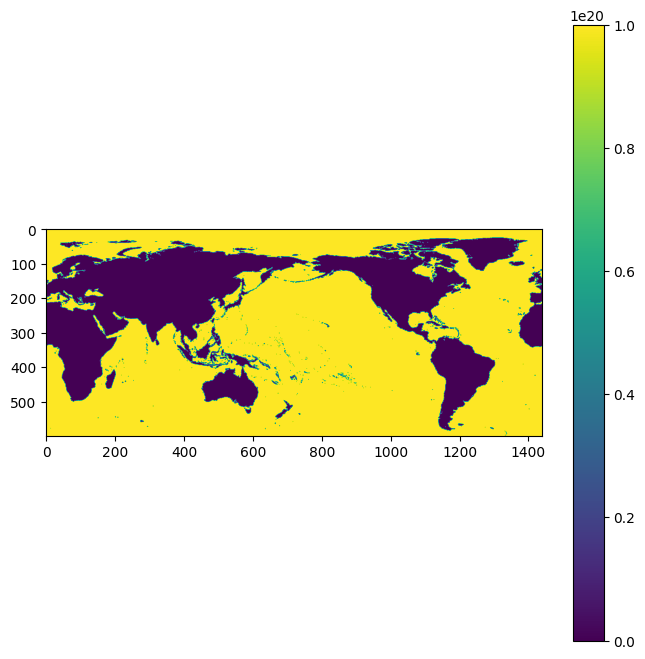

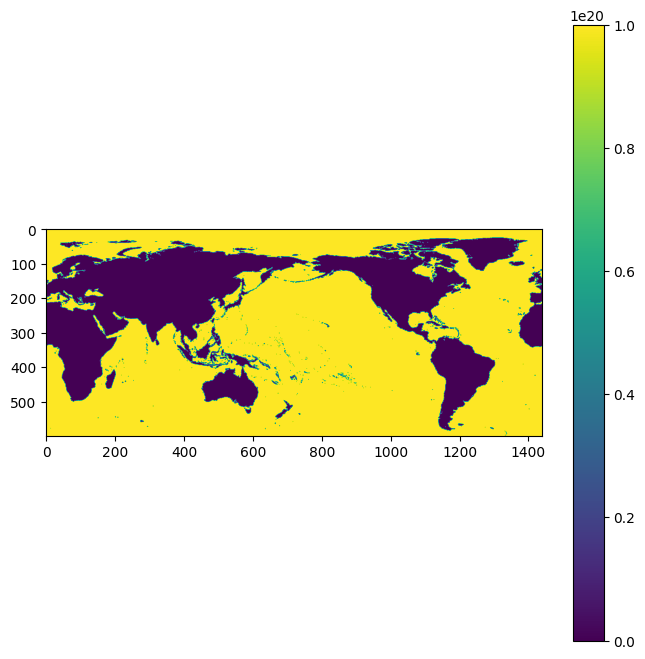

In [5]:
CopyNetCDF(
  f"{tmp_directory}/full.nc", 
  f"{tmp_directory}/full.copy.nc", 
  variable_mappings={"hurs":field},  
  additional_root_attributes={"example":"my-value"},
  create_streamable_version=False)


# show original data at day 360
ds = xr.open_dataset(f"{tmp_directory}/full.nc", group="/", mask_and_scale=False)
ShowImage(ds["hurs"][360,...].values)

# show copied data
ds = xr.open_dataset(f"{tmp_directory}/full.copy.nc", group="/", mask_and_scale=False) 
ShowImage(ds[field][360,...].values)

# Create the IDX

In [6]:
import datetime

# create OpenVisus idx in a separate folder so I can clean it up for debugging purpouse
idx_filename=f"{tmp_directory}/visus.idx"

# I am using arco file format since later I want the data in the cloud
arco="2mb"

visus_data_dir=os.path.splitext(idx_filename)[0]	
print(f"DANGEROUS but needed: removing any old data file from directory={visus_data_dir}")
import shutil
shutil.rmtree(visus_data_dir, ignore_errors=True)

ds = xr.open_dataset(f"{tmp_directory}/full.nc", group="/", mask_and_scale=False) 
data=ds["hurs"][...].values
vmin,vmax=np.min(data),np.max(data)
print(data.shape,data.dtype,vmin,vmax)

ov_field=ov.Field.fromString(f"""{field} {str(data.dtype)} format(row_major) min({vmin}) max({vmax})""")

D,H,W=data.shape
assert(D==365) 

db=ov.CreateIdx(
	url=idx_filename, 
	dims=[W,H], 
	fields=[ov_field], 
	compression="raw", 
	arco=arco,
	time=[year*365,year*365+D,"time_%d/"], # a single NETCDF file covers always 365 days
)

# write IDX dats 
# # NOTE: each Z is a day (offset from the year)
for Z in range(D):
	slice=data[Z,...]
	db.write(slice,time=year*365+Z,field=field)

db.compressDataset(["zip"])

DANGEROUS but needed: removing any old data file from directory=./remove-me/hurs_day_ACCESS-CM2_historical_r1i1p1f1_gn_1950/visus
(365, 600, 1440) float32 -58.728542 1e+20


# Create Streamable NETCDF

The OpenVisus `Streamable.Create` function used the `h5py` library which creates files not always compatible.

So here I am using specialized code for `*.nc` file.

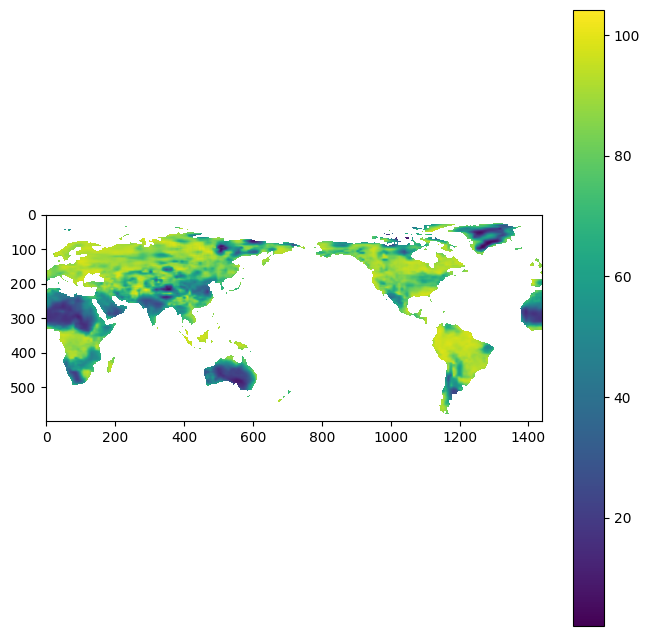

Creating variable name=time dtype=float64 dimensions=('time',) fill_value=None
Creating variable name=hurs_day_ACCESS-CM2_historical_r1i1p1f1_gn dtype=float32 dimensions=('time', 'lat', 'lon') fill_value=1.0000000200408773e+20
Creating variable name=lat dtype=float64 dimensions=('lat',) fill_value=None
Creating variable name=lon dtype=float64 dimensions=('lon',) fill_value=None
old-size=277,751,427 new-size=1,261,509,962 perc=454.19%
 /
   @idx_urls=b"{'default': 'remote', 'remote': 'https://maritime.sealstorage.io/api/v0/s3/utah/nex-gddp-cmip6/visus.idx?cached=arco&access_key=any&secret_key=any&endpoint_url=https://maritime.sealstorage.io/api/v0/s3&cached=arco', 'local': './remove-me/hurs_day_ACCESS-CM2_historical_r1i1p1f1_gn_1950/visus.idx'}"
   @idx_url=b'remote'
   @activity=b'NEX-GDDP-CMIP6'
   @contact=b'Dr. Rama Nemani: rama.nemani@nasa.gov, Dr. Bridget Thrasher: bridget@climateanalyticsgroup.org'
   @Conventions=b'CF-1.7'
   @creation_date=b'2021-10-04T13:59:21.654137+00:00'
  

In [7]:
ds = xr.open_dataset(f"{tmp_directory}/full.nc")
ShowImage(ds["hurs"][360,...].values)

idx_urls={
	
	# people will load the data from the cloud (i.e. later I need to copy files to the cloud)
	"default": "remote",
	"remote": "https://maritime.sealstorage.io/api/v0/s3/utah/nex-gddp-cmip6/visus.idx?cached=arco&access_key=any&secret_key=any&endpoint_url=https://maritime.sealstorage.io/api/v0/s3&cached=arco",

	"local":  f"{tmp_directory}/visus.idx", 
}

CopyNetCDF(
  f"{tmp_directory}/full.nc",
  f"{tmp_directory}/streamable.nc", 
	
	variable_mappings={
		"hurs":field
	}, 

	# note that I am adding some information to the NETCDF file so binary data will be opened leveraging OpenVisus
	additional_root_attributes={
		"idx_urls": idx_urls,
		"idx_url":  idx_urls["default"],
	},
	create_streamable_version=False,
)

Streamable.Print(f"{tmp_directory}/streamable.nc")


# Using Xarray to open streamable netcdf


In [8]:
ds = xr.open_dataset(f"{tmp_directory}/streamable.nc",engine=OpenVisusBackendEntrypoint, prefer="local")
ds

ov.LoadDataset(./remove-me/hurs_day_ACCESS-CM2_historical_r1i1p1f1_gn_1950/visus.idx)
hurs_day_ACCESS-CM2_historical_r1i1p1f1_gn
Adding field  hurs_day_ACCESS-CM2_historical_r1i1p1f1_gn shape  [366, 600, 1440, 22] dtype  float32 labels  ['time', 'lat', 'lon', 'resolution'] Max Resolution  21


<xarray.Dataset> Size: 28GB
Dimensions:                                     (time: 366, lat: 600,
                                                 lon: 1440, resolution: 22)
Coordinates:
  * lat                                         (lat) float64 5kB -59.88 ... ...
  * lon                                         (lon) float64 12kB 0.125 ... ...
Dimensions without coordinates: time, resolution
Data variables:
    hurs_day_ACCESS-CM2_historical_r1i1p1f1_gn  (time, lat, lon, resolution) float32 28GB ...
Attributes: (12/24)
    idx_urls:              {'default': 'remote', 'remote': 'https://maritime....
    idx_url:               remote
    activity:              NEX-GDDP-CMIP6
    contact:               Dr. Rama Nemani: rama.nemani@nasa.gov, Dr. Bridget...
    Conventions:           CF-1.7
    creation_date:         2021-10-04T13:59:21.654137+00:00
    ...                    ...
    history:               2021-10-04T13:59:21.654137+00:00: install global a...
    disclaimer:            This data is considered provisional and subject to...
    external_variables:    areacella
    cmip6_source_id:       ACCESS-CM2
    cmip6_institution_id:  CSIRO-ARCCSS
    cmip6_license:         CC-BY-SA 4.0

Using Max Resolution:  21
Time: 711750, max_resolution: 21, logic_box=(0, 1440, 0, 600), field: hurs_day_ACCESS-CM2_historical_r1i1p1f1_gn


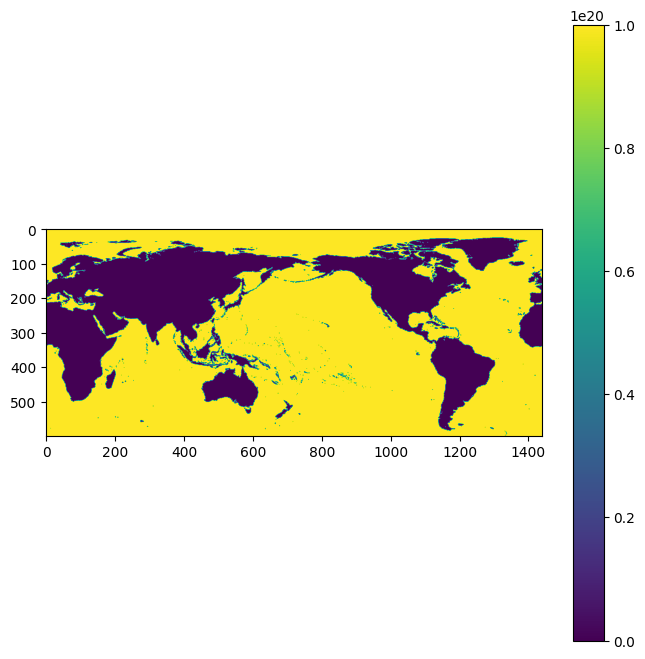

In [9]:
ShowImage(ds["hurs_day_ACCESS-CM2_historical_r1i1p1f1_gn"][0,:,:,0].values)  #since our xarray returns extra axes for time and resolution, filter it out

### Using xarray plot function to plot with metadata

Using Max Resolution:  21
Time: 711750, max_resolution: 21, logic_box=(0, 1440, 0, 600), field: hurs_day_ACCESS-CM2_historical_r1i1p1f1_gn


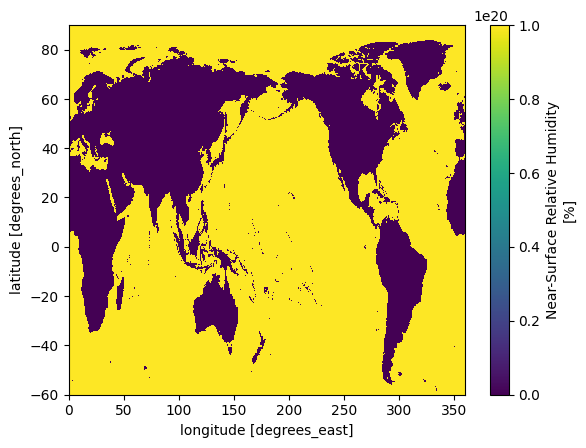

In [10]:
ds["hurs_day_ACCESS-CM2_historical_r1i1p1f1_gn"][0,:,:,0].plot()